In [29]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.utils.data import download_file

from scipy.interpolate import NearestNDInterpolator

from jwst import datamodels

In [30]:
from gwcs.wcstools import grid_from_bounding_box


def get_boxcar_weights(center, hwidth, npix):
    """
    Compute the weights given an aperture center, half widths, and number of pixels
    """
    weights = np.zeros((npix))
    # pixels with full weight
    fullpixels = [max(0, int(center - hwidth + 1)), min(int(center + hwidth), npix)]
    weights[fullpixels[0] : fullpixels[1]] = 1.0

    # pixels at the edges of the boxcar with partial weight
    if fullpixels[0] > 0:
        weights[fullpixels[0] - 1] = hwidth - (center - fullpixels[0])
    if fullpixels[1] < npix:
        weights[fullpixels[1]] = hwidth - (fullpixels[1] - center)

    return weights


def ap_weight_images(
    center, width, bkg_offset, bkg_width, image_size, waves, wavescale=None
):
    """
    Create a weight image that defines the desired extraction aperture
    and the weight image for the requested background regions

    Parameters
    ----------
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    image_size : tuple with 2 elements
        size of image
    waves : array
        wavelegth values
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value

    Returns
    -------
    wimage, bkg_wimage : (2D image, 2D image)
        wimage is the weight image defining the aperature
        bkg_image is the weight image defining the background regions
    """
    wimage = np.zeros(image_size)
    bkg_wimage = np.zeros(image_size)
    hwidth = 0.5 * width
    # loop in dispersion direction and compute weights
    for i in range(image_size[1]):
        if wavescale is not None:
            hwidth = 0.5 * width * (waves[i] / wavescale)

        wimage[:, i] = get_boxcar_weights(center, hwidth, image_size[0])

        # bkg regions
        if (bkg_width is not None) & (bkg_offset is not None):
            bkg_wimage[:, i] = get_boxcar_weights(
                center - hwidth - bkg_offset, bkg_width, image_size[0]
            )
            bkg_wimage[:, i] += get_boxcar_weights(
                center + hwidth + bkg_offset, bkg_width, image_size[0]
            )
        else:
            bkg_wimage = None

    return (wimage, bkg_wimage)


def extract_1dspec(jdatamodel, center, width, bkg_offset, bkg_width, wavescale=None):
    """
    Extract the 1D spectrum using the boxcar method.
    Does a background subtraction as part of the extraction.

    Parameters
    ----------
    jdatamodel : jwst.DataModel
        jwst datamodel with the 2d spectral image
    center : float
        center of aperture in pixels
    width : float
        width of apeture in pixels
    bkg_offset : float
        offset from the extaction edge for the background
        never scaled for wavelength
    bkg_width : float
        width of background region
        never scaled with wavelength
    wavescale : float
        scale the width with wavelength (default=None)
        wavescale gives the reference wavelenth for the width value

    Returns
    -------
    waves, ext1d : (ndarray, ndarray)
        2D `float` array with wavelengths
        1D `float` array with extracted 1d spectrum in Jy
    """
    # should be determined from the gWCS in cal.fits
    image = np.transpose(jdatamodel.data)
    grid = grid_from_bounding_box(jdatamodel.meta.wcs.bounding_box)
    ra, dec, lam = jdatamodel.meta.wcs(*grid)
    lam_image = np.transpose(lam)

    # compute a "rough" wavelength scale to allow for aperture to scale with wavelength
    rough_waves = np.average(lam_image, axis=0)

    # images to use for extraction
    wimage, bkg_wimage = ap_weight_images(
        center,
        width,
        bkg_width,
        bkg_offset,
        image.shape,
        rough_waves,
        wavescale=wavescale,
    )

    # extract the spectrum using the weight image
    if bkg_wimage is not None:
        ext1d_boxcar_bkg = np.average(image, weights=bkg_wimage, axis=0)
        data_bkgsub = image - np.tile(ext1d_boxcar_bkg, (image.shape[0], 1))
    else:
        data_bkgsub = image

    ext1d = np.sum(data_bkgsub * wimage, axis=0)
    # convert from MJy/sr to Jy
    ext1d *= 1e6 * jdatamodel.meta.photometry.pixelarea_steradians

    # compute the average wavelength for each column using the weight image
    # this should correspond directly with the extracted spectrum
    #   wavelengths account for any tiled spectra this way
    waves = np.average(lam_image, weights=wimage, axis=0)

    return (waves, ext1d, data_bkgsub)

def bad_pixel_interpolation(image):
    mask = np.where(~np.isnan(image))
    interp = NearestNDInterpolator(np.transpose(mask), image[mask])
    #interp_cubic = CloughTocher2DInterpolator(np.transpose(mask), image[mask])
    filled_data = interp(*np.indices(image.shape))
    filled_data = filled_data[::-1,:] #+ np.nanmin(filled_data)

    #filled_data_cubic = interp_cubic(*np.indices(image.shape))
    #filled_data_cubic = filled_data_cubic[::-1,:] #+ np.nanmin(filled_data)
    return filled_data

In [39]:
mainurl = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/"
calfilename = "/Users/nasedkin/Documents/jw02044006001_06101_00001_mirimage_cal.fits"

# use a jwst datamodel to provide a good interface to the data and wcs info
cal = np.nan_to_num(datamodels.open(calfilename))
print("cal image")
print(cal.data.shape)
print(np.nanmean(cal.data))
print(np.nanmin(cal.data), np.nanmax(cal.data))
"""
calfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_cal.fits"
s2dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_s2d.fits"
x1dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_x1d.fits"
spatialprofilefilename = "det_image_seq1_MIRIMAGE_P750Lexp1_s2d.fits"
mainurl = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/"

calfile_dld = download_file(mainurl + calfilename)
s2dfile_dld = download_file(mainurl + s2dfilename)
x1dfile_dld = download_file(mainurl + x1dfilename)
spatialprofilefile_dld = download_file(mainurl + spatialprofilefilename)
calfile = calfile_dld + '_cal.fits'
os.rename(calfile_dld, calfile)
s2dfile = s2dfile_dld + '_s2d.fits'
os.rename(s2dfile_dld, s2dfile)
x1dfile = x1dfile_dld + '_x1d.fits'
os.rename(x1dfile_dld, x1dfile)
spatialprofilefile = spatialprofilefile_dld + '_s2d.fits'
os.rename(spatialprofilefile_dld, spatialprofilefile)
cal = datamodels.open(calfile)
s2d = datamodels.open(s2dfile)"""




cal image
(1024, 1032)
26.399803
-1194.5693 6132.3755


'\ncalfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_cal.fits"\ns2dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_s2d.fits"\nx1dfilename = "det_image_seq5_MIRIMAGE_P750Lexp1_x1d.fits"\nspatialprofilefilename = "det_image_seq1_MIRIMAGE_P750Lexp1_s2d.fits"\nmainurl = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/"\n\ncalfile_dld = download_file(mainurl + calfilename)\ns2dfile_dld = download_file(mainurl + s2dfilename)\nx1dfile_dld = download_file(mainurl + x1dfilename)\nspatialprofilefile_dld = download_file(mainurl + spatialprofilefilename)\ncalfile = calfile_dld + \'_cal.fits\'\nos.rename(calfile_dld, calfile)\ns2dfile = s2dfile_dld + \'_s2d.fits\'\nos.rename(s2dfile_dld, s2dfile)\nx1dfile = x1dfile_dld + \'_x1d.fits\'\nos.rename(x1dfile_dld, x1dfile)\nspatialprofilefile = spatialprofilefile_dld + \'_s2d.fits\'\nos.rename(spatialprofilefile_dld, spatialprofilefile)\ncal = datamodels.open(calfile)\ns2d = datamodels.open(s2dfile)'

Text(0.5, 1.0, 'The LRS region')

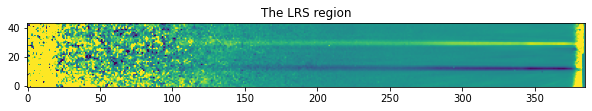

In [40]:

# transpose to make it display better
#data_lrs_reg = np.transpose(s2d.data)
data_lrs_reg = np.transpose(cal.data[7:392,303:347])
data_lrs_reg = bad_pixel_interpolation(data_lrs_reg)
norm_data = simple_norm(data_lrs_reg, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(data_lrs_reg,origin="lower", vmin = -100, vmax = 100)
plt.title("The LRS region")

Text(0.5, 1.0, 'The full image from the MIRI IMAGER detector')

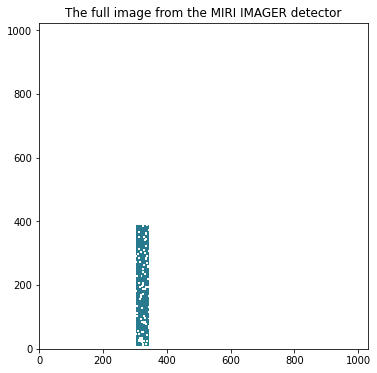

In [41]:
norm_data = simple_norm(cal.data, 'sqrt')
plt.figure(figsize=(6, 6))
plt.imshow(cal.data, norm=norm_data, origin="lower")
plt.title("The full image from the MIRI IMAGER detector")

In [8]:
ext_center = 30
ext_width = 8
bkg_offset = 4
bkg_width = 2

In [43]:
waves_boxcar, ext1d_boxcar, tmpval = extract_1dspec(cal, ext_center, ext_width, None, None)

TypeError: 1D weights expected when shapes of a and weights differ.

In [ ]:
# lrs spatial profile (PSF) as a function of wavelength
# currently, this is just a "high" S/N observation of a flat spectrum source at the same slit position
spatialprofilefilename = "det_image_seq1_MIRIMAGE_P750Lexp1_s2d.fits"
spatialprofilefile_dld = download_file(mainurl + spatialprofilefilename)
spatialprofilefile = spatialprofilefile_dld + '_s2d.fits'
os.rename(spatialprofilefile_dld, spatialprofilefile)

psf = datamodels.open(spatialprofilefile)
# transpose to make it display better
lrspsf = np.transpose(psf.data)
norm_data = simple_norm(lrspsf, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(lrspsf, norm=norm_data, origin="lower")
plt.title("The LRS Spatial Profile (PSF) Observation")


In [ ]:
# Mock a LRS spectral profile reference file
# Sum along the spatial direction and normalize to 1
# assume there is no background (none was included in the MIRISim for the flat spectrum source observation)
# ignore regions far from the source using a scaled boxcar weight image
#   the aperture (psf_width) used in the scaled boxcar weight image could be varied
psf_width = 12.0
(wimage_scaledboxcar, tmpvar) = ap_weight_images(ext_center, 
                                                 psf_width, 
                                                 bkg_offset, 
                                                 bkg_width, 
                                                 data_lrs_reg.shape, 
                                                 waves_boxcar, wavescale=10.0)

psf_weightimage = lrspsf*wimage_scaledboxcar

# generate a 2D image of the column sums for division
max_psf = np.max(psf_weightimage, axis=0)
div_image = np.tile(max_psf, (psf_weightimage.shape[0], 1))
div_image[div_image == 0.0] = 1.0  # avoid divide by zero issues

# normalize 
psf_weightimage /= div_image

# display
norm_data = simple_norm(psf_weightimage, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(psf_weightimage, norm=norm_data, origin="lower")
plt.title("The LRS Spatial Profile Reference Image (Normalized)")


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
y = np.arange(psf_weightimage.shape[0])
ax.plot(y, psf_weightimage[:,150], label="pixel=150")
ax.plot(y, psf_weightimage[:,225], label="pixel=225")
ax.plot(y, psf_weightimage[:,300], label="pixel=300")
ax.plot(y, psf_weightimage[:,370], label="pixel=370")
ax.set_title("Cross-dispersion Cuts")
ax.set_xlim(ext_center-psf_width, ext_center+psf_width)
ax.legend()

In [ ]:
# use the normalized PSF weight image to extract the specrum
# use the background subtracted image from the scaled boxcar extraction
ext1d_psfweight = np.sum(sboxcar_bkgsub_image * psf_weightimage, axis=0)
ext1d_psfweight *= 1e6 * s2d.meta.photometry.pixelarea_steradians

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_psfweight > 0.
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_psfweight[gpts], 'k-', label="psf weighted (bkgsub)")
gpts = ext1d_sboxcar_bkgsub > 0.
ax.plot(waves_sboxcar_bkgsub[gpts], ext1d_sboxcar_bkgsub[gpts], 'k:', label="scaled boxcar (bkgsub)")
ax.set_title("PSF weigthed extracted spectrum")
ax.set_xlabel("wavelength [$\mu$m]")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e-1)
ax.legend()
